# SLT-CE-2: Deterministic Annealing

### References

<ol>
<li> Deterministic annealing for clustering, compression, classification, regression, and related optimization
problems, Kenneth Rose, 1998, http://ieeexplore.ieee.org/document/726788/
</li>
    
<li>
A Ratio Scale Metric and the Compatibility
of Ratio Scales: The Possibility of
Arrow’s Impossibility Theorem, T.L. Saalty, 1994, https://www.sciencedirect.com/science/article/pii/0893965994900930
</li>

<li>
The wine data set, http://www3.dsi.uminho.pt/pcortez/wine5.pdf
</li>
    
<li>
Lecture 4, slide 19, https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture04.pdf
</li>
    
</ol>

### Setup 

In [ ]:
LEGI: 11-912-243

In [17]:
!pip install treelib


In [79]:
import sklearn as skl
import sklearn.cluster as cluster
import sklearn.model_selection as model_selection
import sklearn.svm as svm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make sure to install treelib in the slt-ce conda environment: conda install treelib
import treelib as tl

from sklearn import svm
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

from scipy.linalg import svdvals, eigvalsh, eigvals
from math import exp
from numpy.linalg import norm

#import tensorflow as tf


<h2 style="background-color:#f0b375;">
Section Preliminary
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 0.0 </span>
</h2>

<p style="background-color:#adebad;">
    Implement the function read_X_y_from_csv according to the contract in its docstring.
</p>

In [19]:
def read_X_y_from_csv(sheet, y_names=None):
    """Parse a column data store into X, y arrays

    Args:
        sheet (str): Path to csv data sheet.
        y_names (list of str): List of column names used as labels.

    Returns:
        X (np.ndarray): Array with feature values from columns that are not contained in y_names (n_samples, n_features)
        y (dict of np.ndarray): Dictionary with keys y_names, each key contains an array (n_samples, 1)
                                with the label data from the corresponding column in sheet. 
    """

    # Your code goes here
    X = pd.read_csv('wine-data.csv', sep=',')
    y = {}
    for key in y_names:
      y[key] = X[key].tolist()
      X = X.drop(columns=key)    
    return X, y

<p style="background-color:#adebad;">
Read the wine data [3], which contains 11 physiochemical attributes, and two labels (quality and color).
</p>

In [20]:
X, y = read_X_y_from_csv("wine-data.csv", y_names=["quality", "color"])

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.0 </span>
</h2>

<p style="background-color:#adebad;">
    Read reference [1] about deterministic annealing clustering (DAC). Shortly summarize what they refer to as the <i>preferred implementation</i> of the DAC algorithm.
</p>

In [10]:
The preferred implementation refers to the mass-constrained clustering. The motivation of doing this is to eliminate the annealing process's dependency on the number of coincident codevectors in each effective cluster. The algorithm starts with only one cluster 𝑦0
, the mass center of the dataset. The initial temperature should be larger than 2 times the biggest eigenvalue of the convariance matrix of the posterior distribution 𝑝(𝑥|𝑦0). For each cluster 𝑦𝑖, we first calculate the 𝑝(𝑦𝑖|𝑥) and 𝑝(𝑦𝑖), and then calculate 𝑦𝑖 based on 𝑝(𝑦𝑖|𝑥) and 𝑝(𝑦𝑖). The formula of 𝑦𝑖 is derived by optimizing the cost function 𝐹′=𝐷−𝑇𝐻+𝜆(∑𝑖𝑝𝑖−1), where 𝐷 is the distortion, 𝑇 is the temperature and 𝐻 is the entropy of 𝑌|𝑋. We keep updating the centroids until the current temperature until they converge. We lower the temperature according to the cooling schedule. Later on, we check for each cluster if it is about to split by comparing the critical temperature with the current temperature. When the temperature is lower than the pre-set lowest temperature, we set 𝑇=0 and do the last round update

SyntaxError: invalid syntax (<ipython-input-10-384dc749b9cf>, line 1)

Put your markdown text here

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class DeterministicAnnealing, according to the contract outlined in its docstring.
    You can add more class methods as necessary.
    See http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for complementary information.
</p>

In [64]:
class DeterministicAnnealingClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for DAC
    
    Attributes:
        cluster_centers_ (np.ndarray): Cluster centroids y_i (n_clusters, n_features)
        cluster_probabs_ (np.ndarray): Assignment probability vectors p(y_i | x) for each sample
                                       (n_samples, n_clusters)
        bifurcation_tree_ (treelib.Tree): Tree object that contains information about cluster evolution during
                                          annealing.
                                       
    Parameters:
        n_clusters (int): Maximum number of clusters returned by DAC.
        random_state (int): Random seed.
    """
  
    def __init__(self, n_clusters=8, random_state=42, metric="euclidian", bt=False):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        self.bt = bt
        # Add more parameters, if necessary.
        
    def association_prob(self, x, Y, i, py, T, K, scalar):
        """return a scalar corresponding to p(y_j|x_i)"""
        diff = x - Y
        distortion = np.linalg.norm(diff, axis=1)**2
        q = -distortion/T
        
        exp_arr = np.exp(q-q.max()) # exp-normalize to avoid overflow: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
        denominator = np.dot(py, exp_arr)
        if scalar:
          ap = (py[K-1]*exp_arr)/denominator
        else:
          ap = (py[K-1]*exp_arr[K-1])/denominator
        return ap
        
    def association_prob_arr(self, X, Y, py, K, k, T):
        """For a fixed center and all samples
        Return:
          apa: nd-array (samples, 1)
        """
        samples = X.shape[0]
        apa = np.zeros(samples)
        Y = Y[0:K]
        py = py[0:K]
        
        for i in range(samples):
          apa[i] = self.association_prob(X[i], Y, i, py, T, k, K == 1)
          
        return apa

    def compute_distortion(self, X, Y, K, ap_mat):
      distances = euclidean_distances(X, Y[0:K])
      weighted_distances = distances.T*ap_mat[0:K]
      return weighted_distances.sum()
      
    def ratio_scale(self, x, y, d):
      scale = 1/(d*d)
      scale = tf.constant(scale, dtype=tf.float64)
      s = tf.Variable(0, dtype = tf.float64)
      for i in range(d):
        for j in range(d):
          s = s+(x[i]*y[j])/(x[j]*y[i])
      
      return tf.log(scale*s)
    
    def ratio_scale_cost(self, X, Y, T):
      cost = tf.Variable(0, dtype=tf.float64)
      # print(X.shape, Y.shape)
      samples, features, clusters = X.shape[0], int(X.shape[1]), Y.shape[0]
      for i in range(samples):
        subcost = tf.Variable(0,dtype=tf.float64)
        for j in range(clusters):
          subcost = subcost+tf.exp(-self.ratio_scale(X[i], Y[j], features))/T
        cost = cost + tf.log(subcost)
      
      return -tf.consant(T)*cost/tf.constant(samples)
    
    
    
    def fit(self, X):
        """Compute DAC for input vectors X
        
        Preferred implementation of DAC as described in reference [1].
        Consider to use initialization and reseeding as in sklearn k-means for improved performance.
        
        Args:
            X (np.ndarray): Input array with shape (samples, n_features)
        
        Returns:
            self
        """
        X = X.values
        samples, features = X.shape
        K_max = self.n_clusters
        metric = self.metric
                
        T_min = 0.001
        eta = 0.2
        
        K = 1
        y0 = np.mean(X, axis=0) # The very first center
        
        Y = np.zeros((K_max, features))
        Y[0] = y0
        
        
        
        py = np.zeros(K_max) # p(y_i)
        py[0] = 1
        
        la_max = eigvalsh(np.cov(X.T), check_finite = False)[-1]
        T  = 2*la_max + 1.0
        
        if self.bt:
          # Write to the tree
          cnt = 0
          self.beta = []
          self.bifurcation_tree_ = tl.Tree()
          id_hash_table = {} # map the cluster number to node id
          id_hash_table[0] = 0
          self.bifurcation_tree_.create_node(identifier=0, data={
              "cluster": 0,
              "ref": y0,
              "offset": 0,
              "from": cnt,
              "to": -1,
              "distance": [],
              "direction": 1
          })

        ap_mat = np.zeros((K_max, samples)) # Association probability matrix
        
        if metric == "euclidian":
            while T > T_min:
              if self.bt:
                self.beta.append(1/T)
              Y_old = np.copy(Y) # centroids from last turn
              for i in range(K):
                apa = self.association_prob_arr(X, Y, py, K, i+1, T)
                ap_mat[i] = apa
                py[i] = apa.sum()
                nominator = apa@X
                Y[i] = nominator/py[i]
              
              if not np.allclose(Y, Y_old): # convergence test
                continue
              
              if self.bt:
                # Update the tree
                cnt += 1
                for node in self.bifurcation_tree_.expand_tree():
                  data = self.bifurcation_tree_[node].data
                  if data["to"] != -1: # it has splitted, leave it alone
                    continue
                  dist = np.linalg.norm(Y[data["cluster"]] - data["ref"])*data["direction"] + data["offset"]
                  print("id ", node)
                  data["distance"].append(dist)

                self.beta.append(1/T)
              
              T *= eta # cooling
              
              if K < K_max:
                # check splitting
                for i in range(K):
                  if K >= K_max:
                    continue
                  y = Y[i]
                  coefficient = ap_mat[i]/(py[i]*samples) # p(x) = 1/N
                  Cxy = np.zeros((features, features))
                  for j in range(samples):
                    Cxy += coefficient[j] * np.outer(X[j]-y, X[j]-y)
                   
                  critical = 2*max(eigvals(Cxy, check_finite=False))
                  
                  if T < critical:
                    Y[K] = Y[i]+np.random.normal(0, 1, size=features)
                    py[i] /= 2
                    py[K] = py[i]
                    if self.bt:
                      # Create new nodes
                      offset = self.bifurcation_tree_.get_node(id_hash_table[i]).data["distance"][-1]
                      print("offsert = ",offset)
                      idd = id_hash_table[i]
                      self.bifurcation_tree_.create_node(identifier = idd*13+1, parent=id_hash_table[i], data={
                          "ref": Y[i], # deep copy
                          "cluster": i,
                          "offset": offset,
                          "from": cnt-1,
                          "to": -1,
                          "direction": -1,
                          "distance": [offset]
                      }) # continuation of the original branch
                      
                      id_hash_table[i] = idd*13+1
                      self.bifurcation_tree_.create_node(identifier = idd*13+3, parent=id_hash_table[i], data={
                          "ref": Y[i], # deep copy
                          "cluster": K,
                          "offset": offset,
                          "from": cnt-1,
                          "to": -1,
                          "direction": 1,
                          "distance": [offset]
                      }) # the new branch
                      id_hash_table[K] = idd*13+3
                      self.bifurcation_tree_.get_node(idd).data["to"] = cnt
                    K += 1
            
            if self.bt:
              self.beta.append(T)
              for node in self.bifurcation_tree_.expand_tree():
                  data = self.bifurcation_tree_[node].data
                  if data["to"] == -1: # it has splitted, leave it alone
                    self.bifurcation_tree_[node].data["to"] = cnt
            
            self.prob_y = py
            ap_mat = (ap_mat >= np.max(ap_mat, axis=0)).astype(np.int_)
            
            # When T is smaller than T_min
            for i in range(K):
              apa = ap_mat[i]
              py[i] = apa.sum()
              nominator = apa@X
              Y[i] = nominator/py[i]
       
      
      
      
        elif metric == "ratioscale":     
            X_tf = tf.constant(X.astype('float64'))
            while T > T_min:
              # Use gradient descend to get Y
              Y = np.ones((K, features))
              Y = tf.Variable(Y)
              # print(Y.shape)
              cost_function = self.ratio_scale_cost(X_tf, Y, T)
              print("hi")
              GDO = tf.train.GradientDescendOptimizer(learning_rate = 0.001)
              GDO.minimize(cost_function)
              T *= eta # cooling
              
              if K < K_max:
                # check splitting
                for i in range(K):
                  if K >= K_max:
                    continue
                  y = Y[i]
                  coefficient = ap_mat[i]/(py[i]*samples) # p(x) = 1/N
                  Cxy = np.zeros((features, features))
                  for j in range(samples):
                    Cxy += coefficient[j] * np.outer(X[j]-y, X[j]-y)
                   
                  critical = 2*max(eigvals(Cxy, check_finite=False))
                  
                  if T < critical:
                    Y[K] = Y[i]+np.random.normal(0, 1, size=features)
                    py[i] /= 2
                    py[K] = py[i]
                    K += 1
            
            self.prob_y = py
            ap_mat = (ap_mat >= np.max(ap_mat, axis=0)).astype(np.int_)
            
            # When T is smaller than T_min
            for i in range(K):
              apa = ap_mat[i]
              py[i] = apa.sum()
              nominator = apa@X
              Y[i] = nominator/py[i]
        
        
        self.cluster_centers = Y
        self.cluster_probabs = ap_mat
        
        
        return self
      
    def fit_phase_transition(self, X):
        """Compute DAC for input vectors X
        
        Preferred implementation of DAC as described in reference [1].
        Consider to use initialization and reseeding as in sklearn k-means for improved performance.
        
        Args:
            X (np.ndarray): Input array with shape (samples, n_features)
        
        Returns:
            self
        """
        X = X.values
        samples, features = X.shape
        K_max = self.n_clusters
        metric = self.metric
                
        T_min = 0.001
        eta = 0.18
        
        K = 1
        y0 = np.mean(X, axis=0) # The very first center
        
        Y = np.zeros((K_max, features))
        Y[0] = y0
        
        
        
        py = np.zeros(K_max) # p(y_i)
        py[0] = 1
        
        la_max = eigvalsh(np.cov(X.T), check_finite = False)[-1]
        T  = 2*la_max + 1.0
        
        self.distortion = [] # record each distortion at each temperature
        self.eff_clusters = [] # record each distortion at each temperature
        self.beta = []
        self.emergence = []
        cnt = 0

        ap_mat = np.zeros((K_max, samples)) #probability matrix
        
        if metric == "euclidian":
            while T > T_min:
              Y_old = np.copy(Y) # centroids from last turn
              for i in range(K):
                apa = self.association_prob_arr(X, Y, py, K, i+1, T)
                ap_mat[i] = apa
                py[i] = apa.sum()
                nominator = apa@X
                Y[i] = nominator/py[i]
              
              if not np.allclose(Y, Y_old): # convergence test
                continue
              
              self.distortion.append(self.compute_distortion(X, Y, K,ap_mat)) # append the distortion corresponding to the current temperature
              self.beta.append(1/T) # append the current temperature
              self.eff_clusters.append(K)
              
              T *= eta # temperature down
              
              K_old = K
              if K < K_max:
                # check splitting
                for i in range(K):
                  if K >= K_max:
                    continue
                  y = Y[i]
                  coefficient = ap_mat[i]/(py[i]*samples) # p(x) = 1/N
                  Cxy = np.zeros((features, features))
                  for j in range(samples):
                    Cxy += coefficient[j] * np.outer(X[j]-y, X[j]-y)
                   
                  critical = 2*max(eigvals(Cxy, check_finite=False))
                  
                  if T < critical:
                    Y[K] = Y[i]+np.random.normal(0, 1, size=features)
                    py[i] /= 2
                    py[K] = py[i]
                    K += 1
              
              if K_old < K:
                self.emergence.append(cnt)
            
              cnt += 1

            self.prob_y = py
            ap_mat = (ap_mat >= np.max(ap_mat, axis=0)).astype(np.int_)
            
            # When T is smaller than T_min
            for i in range(K):
              apa = ap_mat[i]
              py[i] = apa.sum()
              nominator = apa@X
              Y[i] = nominator/py[i]
        
        elif metric == "ratioscale":
            
            # code for extension
            pass
            
        self.cluster_centers = Y
        self.cluster_probabs = ap_mat
        
        
        return self
    
    def predict(self, X):
        """Predict assignment probability vectors for each sample in X.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            P (np.ndarray): Assignment probability vectors (new_samples, n_clusters) 
        """
        X = X.values
        samples, features = X.shape
        ap_mat = np.zeros((self.n_clusters, samples))
        
        for i in range(self.n_clusters):
          apa = self.association_prob_arr(X, self.cluster_centers, self.prob_y, self.n_clusters, i+1, T=10)
          ap_mat[i] = apa
        
        return ap_mat.T
    
    def transform(self, X):
        """Transform X to a cluster-distance space.
        
        In the new space, each dimension is the distance to the cluster centers. 
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            Y (np.ndarray): Cluster-distance vectors (new_samples, n_clusters)
        """
        check_is_fitted(self, ["cluster_centers"])
        X = X.values
        Y = euclidean_distances(X, self.cluster_centers)
        
        
        return Y
    
    def plot_bifurcation(self):
        """Show the evolution of cluster splitting"""
        check_is_fitted(self, ["bifurcation_tree_"])
        
        tree = self.bifurcation_tree_
        fig, ax = plt.subplots()
        ax.set_ylim(0,0.03)
        for node in tree.expand_tree():
          x = tree[node].data["distance"]
          f = tree[node].data["from"]
          t = tree[node].data["to"]
          beta = self.beta[f:t]
          ax.plot(x, beta)
        
        return None
        

<p style="background-color:#adebad;">
    Create an instance of your DAC class with n_clusters = 2 and <b>fit the first 6000 samples</b> of the wine data set. Record the execution time. Furthermore, create an instance of the sklearn k-means class, and fit it with the same parameters. Again record the execution time.
</p>

In [65]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                        y["color"],
                                                                        train_size=6000,
                                                                        random_state=42)

In [66]:
%%time
DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42)
DAC.fit(X_train)

CPU times: user 21 s, sys: 288 ms, total: 21.3 s
Wall time: 5.31 s


DeterministicAnnealingClustering(bt=False, metric='euclidian', n_clusters=2,
                                 random_state=42)

In [67]:
%%time
kmeans = cluster.KMeans(n_clusters=2,random_state=42)
kmeans.fit(X_train)

CPU times: user 284 ms, sys: 0 ns, total: 284 ms
Wall time: 71 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> 
            Implement the <b>predict method</b> for the template class DAC, according to the contract outlined in its docstring.
        </li>
        <li>
            Use DAC.predict and kmeans.predict to predict the cluster labels of X_test.
        </li>
        <li>
            Compute the confusion matrix between the two predictions as described in <br>
            http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        </li>
    </ul>
</p>

In [68]:
%%time
y_kmeans = kmeans.predict(X_test)

CPU times: user 5.31 ms, sys: 100 µs, total: 5.41 ms
Wall time: 1.3 ms


In [69]:
%%time
y_DAC = DAC.predict(X_test)

CPU times: user 97.6 ms, sys: 12.2 ms, total: 110 ms
Wall time: 25.8 ms


<ul style="background-color:#adebad;">
<li> Before we can compute the confusion matrix, we need to perform some post-processing on the DAC cluster assignments.
    Explain what the function postprocess (defined below) does, and why we need it. To do so, complete the docstring of the function postprocess.
        </li>
</ul>

In [70]:
def postprocess(y_DAC, y_kmeans):
    """The purpose of this function is to make
    the results from two methods comparable. Because the indices of 
    clusters may be different in two methods, we have to caliberate the DAC's
    cluster assignments according to kmeans'. 
    Args:
            y_DAC (np.ndarray): (fuzzy) Clustering assignment by DAC (samples, n_features)
            y_kmeans (np.ndarray): Clustering assignment by kmeans (samples, )
        
    Returns:
            y_DAC_new (np.ndarray): Caliberated clustering assignment by DAC (samples, )
    """
    
    y_DAC_hard = np.argmax(y_DAC, axis=1)
    
    n_clusters = len(np.unique(y_DAC_hard))
    dac2kmeans = []
    for cluster in range(n_clusters):
        argmax = np.argmax(y_DAC[:, cluster])
        dac2kmeans.append(y_kmeans[argmax])
        
    y_DAC_new = []
    for dac_label in y_DAC_hard:
        y_DAC_new.append(dac2kmeans[dac_label])
        
    return np.array(y_DAC_new)

In [71]:
cm = skl.metrics.confusion_matrix(y_kmeans, postprocess(y_DAC, y_kmeans))
print(cm.ravel())

[287   1   0 209]


<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class DAC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use DAC.transform and kmeans.transform to transform both, X_train and X_test. 
        </li>
       
</ul>

In [76]:
X_train_DAC = DAC.transform(X_train)
X_test_DAC = DAC.transform(X_test)

X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

<ul style="background-color:#adebad;">
        <li>
        Fit an SVM classifier with default parameters to the untransformed data, and to the transformed data.
        Compare the performance of predicting whether the color of a wine is red or white.
        </li>
    </ul>

In [84]:
from sklearn import svm
svm = svm.SVC(random_state=42)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.9275653923541247

In [85]:
from sklearn import svm
svm_DAC = svm.SVC(random_state=42)
svm_DAC.fit(X_train_DAC, y_train)
svm_DAC.score(X_test_DAC, y_test)

0.9134808853118712

In [86]:
from sklearn import svm
svm = svm.SVC(random_state=42)
svm.fit(X_train_kmeans, y_train)
svm.score(X_test_kmeans, y_test)

0.9134808853118712

<ul style="background-color:#adebad;">
        <li>
        Produce two scatter plots, one for X_train_DAC and one for X_train_kmeans.<br>
        Make the marker color indicate the wine color.
        </li>
    </ul>

In [87]:
white_idx = []
red_idx = []
for cnt, color in enumerate(y_train):
  if color == "red":
    red_idx.append(cnt)
  else:
    white_idx.append(cnt)

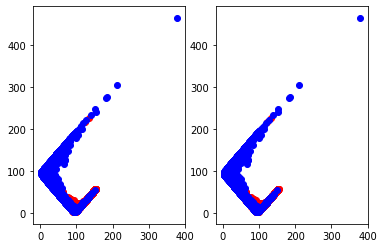

In [89]:
plt.subplot(121)
plt.scatter(X_train_DAC[red_idx, 0], X_train_DAC[red_idx,1], c='red')
plt.scatter(X_train_DAC[white_idx, 0], X_train_DAC[white_idx,1], c='blue')
plt.subplot(122)
plt.scatter(X_train_kmeans[red_idx, 0], X_train_kmeans[red_idx,1], c='red')
plt.scatter(X_train_kmeans[white_idx, 0], X_train_kmeans[white_idx,1], c='blue')

<ul style="background-color:#adebad;">
    <li>
        Create a fixed 2D embedding (e.g. with LLE, t-SNE, MDS) of the wine data and color the markers according to quality and color. Fit and transform X_train with DAC(n_clusters=3,4,5,6,7,8,...). Produce a plot of the SVM score svm_DAC.score(X_test_DAC, y_test) as a function of n_clusters.. Each time use marker shapes to display the cluster memberships, and compare to the labels color and quality.
    </li>
</ul>

In [ ]:
"""
    %%time
    lle = skl.manifold.LocallyLinearEmbedding(random_state=...)
    lle.fit(...)
"""

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>
<ul style="background-color:#adebad;">
        <li>
            Produce a phase diagram plot of the expected distortion D, as shown in figure 2 of reference [1]. For this, extend DAC.fit to save the expected distortion during annealing as an additional attribute self.distortion.
            You might also want to save the number of effective clusters and the temperature along the way.
        </li>
    </ul>
</p>

<ul style="background-color:#adebad;">
        <li>
        Implement DAC.plot_bifurcation, which should create a bifurcation plot as shown on slide 19 of lecture 3. As our data is not 1-dimensional as in the lecture slide, we will have to adapt our scheme, so that the distances between nodes of the tree make sense.<br>
        Modify DAC.fit to keep track of the distances, using the tree object DAC.bifurcation\_tree\_. When a cluster splits, it creates two child nodes. Each node should store its centroid vector, and the distance to the parent centroid vector. After splitting, the parent node is not updated anymore.<br>
        In the bifurcation plot, the horizontal distance of a child node to its parent node should be exactly the distance to the parent centroid vector. The two child nodes should move in opposite directions, i.e. one to the left of the parent and one to the right.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Argue how reasonable our method of plotting the bifurcation is. Explain how the 1D-distances between nodes (i.e. nodes that are not siblings) do not correspond exactly to the distances between centroids. Suggest ideas for improvement.
        </li>
    </ul>

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
            So far, our implementation of DAC assumed that our data is compatible with the euclidian metric. Argue why this assumption is not justified for the wine-data.
        </li>
    </ul>
</p>



<ul style="background-color:#adebad;">
    <li>
        All the features of the wine-data set are measured on a ratio scale, which is incompatible with the euclidian metric (Remark: this is not the complete answer to problem 6, argue why they are not compatible). A more appropriate distance is proposed in reference [2]:
            <br><br>
            $d(x,y)=\log{ \frac{1}{d^2} \sum_{i,j=1}^d \frac{x_i}{x_j} \frac{y_j}{y_i}}$
            <br><br>
            Extend DAC.fit to the case of metric == ratioscale, using d(x,y) as given above.<br>
            Hint 1: As this distance does not give a closed form update formula for the centroids $y$, you will need to do gradient descent to update the centroids. You can either calculate the gradient by hand, or use an automatic differentiation tool like Tensorflow. If you calculate the gradient by hand, provide the formula in Latex below.
                    <br>
            Hint 2: Keep in mind the possibility of negative definite matrices and appropriate regularization when solving for the critical temperature of the ratio scale approach.
        </li>



<ul style="background-color:#adebad;">
    <li>
    Perform experiments to compare the euclidian and ratioscale metrics.
    </li>
</ul>

<h2 style="background-color:#4286f4;"> Comments </h2>

Let us know what you liked about this exercise, and what we can improve!